**FROZEN LAKE - MONTE CARLO METODE**

Uvoz biblioteka i okruženje

In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)

n_states = env.observation_space.n
n_actions = env.action_space.n


Zajedničke pomoćne funkcije

ε-greedy politika

In [13]:
def epsilon_greedy(env, state, Q, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        q_vals = [Q[(state, a)] for a in range(env.action_space.n)]
        return int(np.argmax(q_vals))


Generisanje jedne epizode (za Monte Carlo)

In [14]:
def generate_episode(env, Q, epsilon):
    episode = []
    state, _ = env.reset()
    done = False

    while not done:
        action = epsilon_greedy(env, state, Q, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode.append((state, action, reward))
        state = next_state

    return episode


Izvlačenje determinističke politike iz Q

In [15]:
def extract_policy(Q, env):
    policy = {}
    for s in range(env.observation_space.n):
        q_vals = [Q[(s, a)] for a in range(env.action_space.n)]
        policy[s] = int(np.argmax(q_vals))
    return policy


Evaluacija politike (uspešnost)

In [16]:
def evaluate_policy(env, policy, episodes=1000):
    wins = 0

    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward == 1:
            wins += 1

    return wins / episodes


NAIVNI Every-Visit Monte Carlo

In [17]:
def monte_carlo_every_visit_naive(
    env,
    n_episodes=50000,
    gamma=0.99,
    epsilon=0.1
):
    Q = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    success_history = []

    for ep in range(n_episodes):
        episode = generate_episode(env, Q, epsilon)
        G = 0

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r

            returns_sum[(s, a)] += G
            returns_count[(s, a)] += 1
            Q[(s, a)] = returns_sum[(s, a)] / returns_count[(s, a)]

        if (ep + 1) % 1000 == 0:
            policy = extract_policy(Q, env)
            success = evaluate_policy(env, policy, episodes=200)
            success_history.append(success)

        if (ep + 1) % 5000 == 0:
            print(f"Naive MC | Episode {ep+1}/{n_episodes}")

    return Q, success_history


INKREMENTALNI Every-Visit Monte Carlo

In [18]:
def monte_carlo_every_visit_incremental(
    env,
    n_episodes=50000,
    gamma=0.99,
    epsilon=0.1,
    alpha=0.02
):
    Q = defaultdict(float)
    success_history = []

    for ep in range(n_episodes):
        episode = generate_episode(env, Q, epsilon)
        G = 0

        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            Q[(s, a)] += alpha * (G - Q[(s, a)])

        if (ep + 1) % 1000 == 0:
            policy = extract_policy(Q, env)
            success = evaluate_policy(env, policy, episodes=200)
            success_history.append(success)

        if (ep + 1) % 5000 == 0:
            print(f"Incremental MC | Episode {ep+1}/{n_episodes}")

    return Q, success_history


Testiranje Monte Carlo

In [19]:
# NAIVNI MC
Q_mc, success_mc = monte_carlo_every_visit_naive(env)

# INKREMENTALNI MC
#Q_mc, success_mc = monte_carlo_every_visit_incremental(env)


Naive MC | Episode 5000/50000
Naive MC | Episode 10000/50000
Naive MC | Episode 15000/50000
Naive MC | Episode 20000/50000
Naive MC | Episode 25000/50000
Naive MC | Episode 30000/50000
Naive MC | Episode 35000/50000
Naive MC | Episode 40000/50000
Naive MC | Episode 45000/50000
Naive MC | Episode 50000/50000


Graf uspešnosti (Monte Carlo)

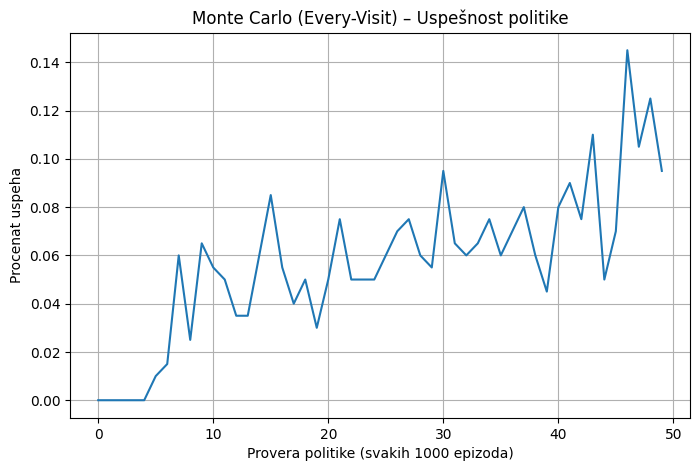

In [20]:
plt.figure(figsize=(8,5))
plt.plot(success_mc)
plt.xlabel("Provera politike (svakih 1000 epizoda)")
plt.ylabel("Procenat uspeha")
plt.title("Monte Carlo (Every-Visit) – Uspešnost politike")
plt.grid()
plt.show()


Vizualizacija politike

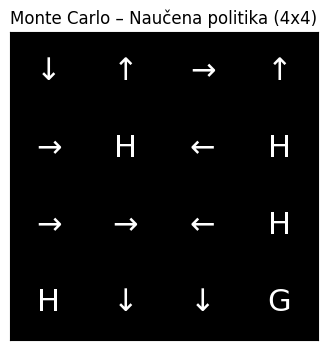

In [21]:
policy_mc = extract_policy(Q_mc, env)

arrow_map = {
    0: "←",
    1: "↓",
    2: "→",
    3: "↑"
}

desc = env.unwrapped.desc.astype(str)
grid = np.full((4, 4), " ", dtype=object)

for s in range(n_states):
    i, j = divmod(s, 4)
    if desc[i, j] == "H":
        grid[i, j] = "H"
    elif desc[i, j] == "G":
        grid[i, j] = "G"
    else:
        grid[i, j] = arrow_map[policy_mc[s]]

plt.figure(figsize=(4,4))
plt.imshow(np.zeros((4, 4)), cmap="gray")
plt.xticks([])
plt.yticks([])

for i in range(4):
    for j in range(4):
        plt.text(j, i, grid[i, j],
                 ha="center", va="center",
                 fontsize=22, color="white")

plt.title("Monte Carlo – Naučena politika (4x4)")
plt.show()


**FROZEN LAKE - Q-LEARING I SARSA**

Implementacija Q-learning algoritma

In [22]:
def q_learning(
    env,
    n_episodes=50000,
    gamma=0.99,
    epsilon=0.1,
    alpha=0.1
):
    Q = defaultdict(float)
    success_history = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = epsilon_greedy(env, state, Q, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            best_next = max(Q[(next_state, a)] for a in range(env.action_space.n))
            Q[(state, action)] += alpha * (
                reward + gamma * best_next - Q[(state, action)]
            )

            state = next_state

        if (ep + 1) % 1000 == 0:
            policy = extract_policy(Q, env)
            success = evaluate_policy(env, policy, episodes=200)
            success_history.append(success)

        if (ep + 1) % 5000 == 0:
            print(f"Q-learning | Episode {ep+1}/{n_episodes}")

    return Q, success_history


Pokretanje Q-learning eksperimenta

In [23]:
Q_ql, success_ql = q_learning(env)


Q-learning | Episode 5000/50000
Q-learning | Episode 10000/50000
Q-learning | Episode 15000/50000
Q-learning | Episode 20000/50000
Q-learning | Episode 25000/50000
Q-learning | Episode 30000/50000
Q-learning | Episode 35000/50000
Q-learning | Episode 40000/50000
Q-learning | Episode 45000/50000
Q-learning | Episode 50000/50000


Graf uspešnosti (Q-learning)

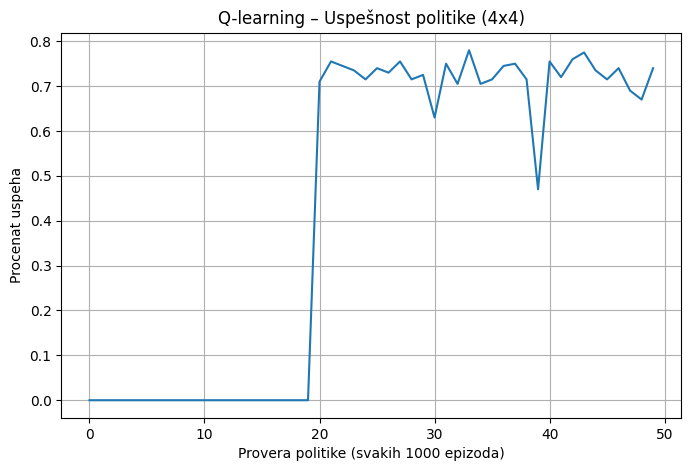

In [24]:
plt.figure(figsize=(8,5))
plt.plot(success_ql)
plt.xlabel("Provera politike (svakih 1000 epizoda)")
plt.ylabel("Procenat uspeha")
plt.title("Q-learning – Uspešnost politike (4x4)")
plt.grid()
plt.show()


Vizualizacija Q-learning politike

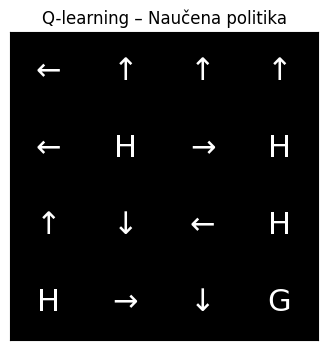

In [25]:
policy_ql = extract_policy(Q_ql, env)

grid = np.full((4, 4), " ", dtype=object)

for s in range(n_states):
    i, j = divmod(s, 4)
    if desc[i, j] == "H":
        grid[i, j] = "H"
    elif desc[i, j] == "G":
        grid[i, j] = "G"
    else:
        grid[i, j] = arrow_map[policy_ql[s]]

plt.figure(figsize=(4,4))
plt.imshow(np.zeros((4, 4)), cmap="gray")
plt.xticks([])
plt.yticks([])

for i in range(4):
    for j in range(4):
        plt.text(j, i, grid[i, j],
                 ha="center", va="center",
                 fontsize=22, color="white")

plt.title("Q-learning – Naučena politika")
plt.show()


Implementacija SARSA algoritma

In [26]:
def sarsa(
    env,
    n_episodes=50000,
    gamma=0.99,
    epsilon=0.1,
    alpha=0.1
):
    Q = defaultdict(float)
    success_history = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(env, state, Q, epsilon)
        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy(env, next_state, Q, epsilon)

            Q[(state, action)] += alpha * (
                reward + gamma * Q[(next_state, next_action)] - Q[(state, action)]
            )

            state, action = next_state, next_action

        if (ep + 1) % 1000 == 0:
            policy = extract_policy(Q, env)
            success = evaluate_policy(env, policy, episodes=200)
            success_history.append(success)

        if (ep + 1) % 5000 == 0:
            print(f"SARSA | Episode {ep+1}/{n_episodes}")

    return Q, success_history


Pokretanje SARSA eksperimenta

In [27]:
Q_sarsa, success_sarsa = sarsa(env)


SARSA | Episode 5000/50000
SARSA | Episode 10000/50000
SARSA | Episode 15000/50000
SARSA | Episode 20000/50000
SARSA | Episode 25000/50000
SARSA | Episode 30000/50000
SARSA | Episode 35000/50000
SARSA | Episode 40000/50000
SARSA | Episode 45000/50000
SARSA | Episode 50000/50000


Graf uspešnosti (SARSA)

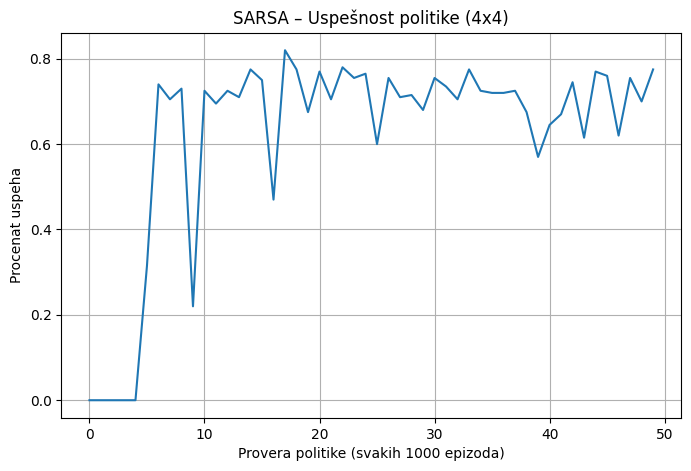

In [28]:
plt.figure(figsize=(8,5))
plt.plot(success_sarsa)
plt.xlabel("Provera politike (svakih 1000 epizoda)")
plt.ylabel("Procenat uspeha")
plt.title("SARSA – Uspešnost politike (4x4)")
plt.grid()
plt.show()


Vizualizacija SARSA politike

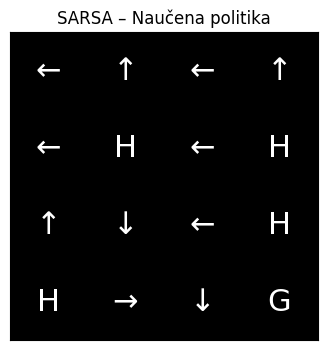

In [29]:
policy_sarsa = extract_policy(Q_sarsa, env)

grid = np.full((4, 4), " ", dtype=object)

for s in range(n_states):
    i, j = divmod(s, 4)
    if desc[i, j] == "H":
        grid[i, j] = "H"
    elif desc[i, j] == "G":
        grid[i, j] = "G"
    else:
        grid[i, j] = arrow_map[policy_sarsa[s]]

plt.figure(figsize=(4,4))
plt.imshow(np.zeros((4, 4)), cmap="gray")
plt.xticks([])
plt.yticks([])

for i in range(4):
    for j in range(4):
        plt.text(j, i, grid[i, j],
                 ha="center", va="center",
                 fontsize=22, color="white")

plt.title("SARSA – Naučena politika")
plt.show()
